##### PyMC3 Examples

# Model Selection - Bayes Factor

@author: Jonathan Sedar  
@email: jon@sedar.co  
@date: Mon 28 Dec 2015  

**A minimal reproducable example of Model Selection using Bayes Factor.**

+ This example evaluates two different regression models and declares which has the better fit according to a Bayes Factor comparison.
+ The example is adapted specifically from Jake Vanderplas' [recent blogpost](https://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/) on model selection, for which he used an emcee sampler and numpy-based likelihood. The main purpose of this Notebook is to create a PyMC3-based version.
+ The dataset is tiny and generated within this Notebook. It contains errors in the measured value (y) only.


**Note:**

+ Python 3.4 project using latest available [PyMC3](https://github.com/pymc-devs/pymc3)
+ Developed using [ContinuumIO Anaconda](https://www.continuum.io/downloads) distribution on a Macbook Pro 3GHz i7, 16GB RAM, OSX 10.10.5.  
+ Finally, if runs become unstable or Theano throws weird errors, try clearing the cache `$> theano-cache clear` and rerunning the notebook.


**Package Requirements (shown as a conda-env YAML):**
```
$> less conda_env_pymc3_examples.yml

name: pymc3_examples
    channels:
      - defaults
    dependencies:
      - python=3.4
      - ipython
      - ipython-notebook
      - ipython-qtconsole
      - numpy
      - scipy
      - matplotlib
      - pandas
      - seaborn
      - patsy  
      - pip

$> conda env create --file conda_env_pymc3_examples.yml

$> source activate pymc3_examples

$> pip install --process-dependency-links git+https://github.com/pymc-devs/pymc3

```

# Setup

In [1]:
%matplotlib inline
%qtconsole --colors=linux

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import optimize
import pymc3 as pm
import theano as thno
import theano.tensor as T 

# configure some basic options
sns.set(style="darkgrid", palette="muted")
pd.set_option('display.notebook_repr_html', True)
plt.rcParams['figure.figsize'] = 12, 8
np.random.seed(0)

## Local Functions

In [355]:
def generate_data(n=20, a=1, b=1, c=0, p=0, standardize=True):
    '''
    Create an example dataset based on simple model with noise in y
    y ~ a + bx + cx^2 + e

    NOTE: sigma_y takes on a different meaning here as the generative, 
    inherent noise in the values, rather than experimental error,
    so we shouldn't the known sigma_y values in models.
    '''
   
    ## setup dataframe for observations
    df = pd.DataFrame({'x':np.random.uniform(0,20,n)})
    df['sigma_y'] = np.random.uniform(-20,20,n) #np.random.normal(0,10,n) #<- inherent noise
    df['outlier'] = np.random.binomial(1,p,n)
    
    ## create linear model
    df['y'] = a + b * (df['x']) + c * (df['x'])**2 + df['sigma_y']
        
    ## add extreme noise for outliers
    idx = df['outlier'] == 1
#     bimodal = np.max(np.vstack([np.random.normal(-1,1,1000),np.random.normal(1,1,1000)]),0)
    df.loc[idx,'y'] = df.loc[idx,'y'].apply(lambda x: x * np.random.uniform(0.6,1.4,1)[0])

    ## standardize, round and return
    if standardize:
        dfs = df[['y','sigma_y','outlier']].copy()
        dfs['x'] = (df['x'] - df['x'].mean(0)) / df['x'].std(0)
        df = dfs
    
    for col in ['y','sigma_y','x']:
        df[col] = np.round(df[col],3)

    ordr = 'linear' if c == 0 else 'quadratic'
        
    return df, ordr


## Create and View Data

We'll generate a dummy dataset based on a specific distribution, so we can better evaluate the correctness of the automated model selection later

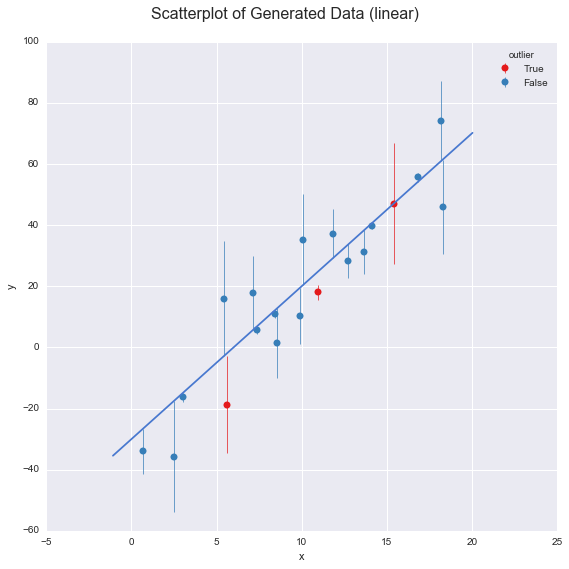

In [356]:
a = -30
b = 5
p = 0.2

df, ordr = generate_data(n=20, a=a, b=b, p=p, standardize=False)

g = sns.FacetGrid(df, size=8, hue='outlier', hue_order=[True,False],
                  palette='Set1', legend_out=False)

_ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', marker="o", ls='', elinewidth=0.7).add_legend()

plotx = np.linspace(df['x'].min() - np.ptp(df['x'])/10
                        ,df['x'].max() + np.ptp(df['x'])/10, 2)
ploty = a + b*plotx

_ = plt.plot(plotx,ploty)

plt.subplots_adjust(top=0.92)
_ = g.fig.suptitle('Scatterplot of Generated Data ({})'.format(ordr), fontsize=16)

**Observe**:  

+ As you might expect, this dummy dataset behaves roughly according to the inputted params, with some noise and outliers

---

---

# Create Conventional OLS Model

The *linear model* is really simple and conventional:

$$\bf{y} = \beta^{T} \bf{X} + \bf{\sigma}$$

where:  

$\beta$ = coefs = $\{1, \beta_{j \in X_{j}}\}$  
$\sigma$ = the measured error in $y$ in the dataset `sigma_y`

##### Define model

**NOTE:**
+ We're using a simple linear OLS model with Normally distributed priors so that it behaves like a ridge regression

In [295]:
with pm.Model() as mdl_ols:
    
    ## Define weakly informative Normal priors to give Ridge regression
    b0 = pm.Normal('b0', mu=0, sd=100)
    b1 = pm.Normal('b1', mu=0, sd=100)
 
    ## Define linear model
    yest = b0 + b1 * df['x']

    ## Define Normal likelihood with HalfNormal noise
    sigma_y = pm.HalfNormal('sigma_y', sd=100)
    likelihood = pm.Normal('likelihood', mu=yest, sd=sigma_y**2, observed=df['y'])


##### Sample

In [296]:
with mdl_ols:

    ## find MAP using Powell, seems to be more robust
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell, disp=True)

    ## take samples
    traces_ols = pm.sample(2000, start=start_MAP, step=pm.NUTS(), progressbar=True)

Optimization terminated successfully.
         Current function value: 90.839914
         Iterations: 6
         Function evaluations: 217
 [-----------------100%-----------------] 2000 of 2000 complete in 8.3 sec

##### View Traces

**NOTE**: I'll 'burn' the traces to only retain the final 1000 samples

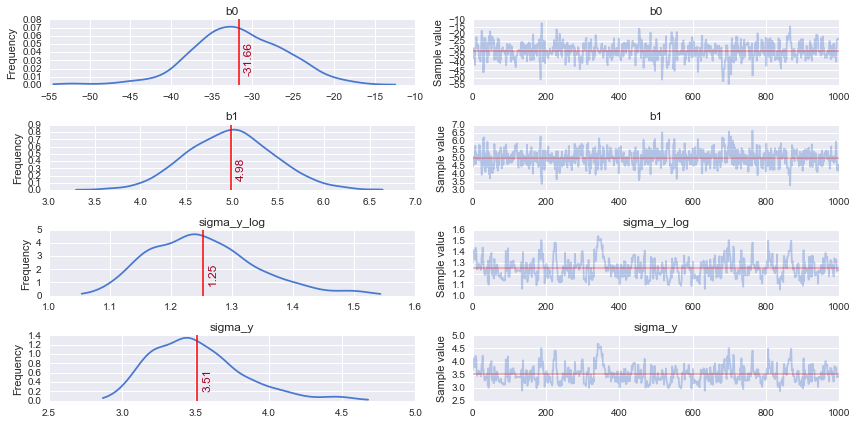

In [297]:
kp = 1000
ax = pm.traceplot(traces_ols[-kp:], figsize=(12,len(traces_ols.varnames)*1.5),
                lines={k: v['mean'] for k, v in pm.df_summary(traces_ols[-kp:]).iterrows()})

for i, mn in enumerate(pm.df_summary(traces_ols[-kp:])['mean']):
    ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points'
                    ,rotation=90, va='bottom', fontsize='large', color='#AA0022')

##### View Posterior Predictive Fit

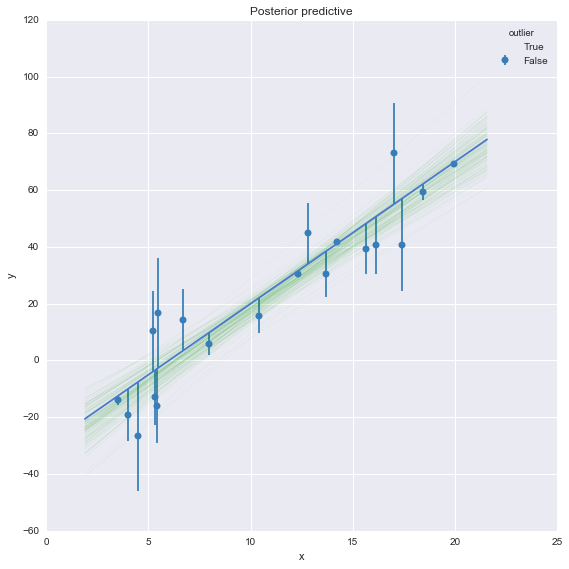

In [298]:
g = sns.FacetGrid(df, size=8, hue='outlier', hue_order=[True,False],
                  palette='Set1', legend_out=False)

lm = lambda x, samp: samp['b0'] + samp['b1'] * x
xrng = df['x'].max() - df['x'].min()

pm.glm.plot_posterior_predictive(traces_ols[-1000:]
        ,eval=np.linspace(df['x'].min() - np.ptp(df['x'])/10
                        ,df['x'].max() + np.ptp(df['x'])/10, 10)
        ,lm=lm, samples=200, color='#00AA00', alpha=.1)

_ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', marker="o", ls='').add_legend()


plotx = np.linspace(df['x'].min() - np.ptp(df['x'])/10
                        ,df['x'].max() + np.ptp(df['x'])/10, 10)
ploty = -30 + 5* plotx

_ = plt.plot(plotx,ploty)

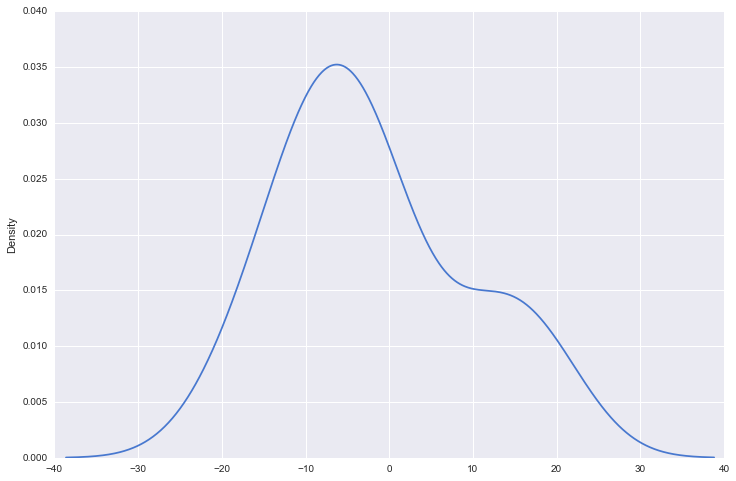

In [299]:
df['sigma_y'].plot(kind='kde')

---

---

# next

---